In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchinfo import summary

In [2]:
def load_root_data(root_files, element_to_index):
    X, Y, carbon_fractions = [], [], []
    for path in root_files:
        with uproot.open(path) as file:
            # Load and normalize spectrum (X)
            spectrum = file["Edep (noise)"].values()
            spectrum_min = np.min(spectrum)
            spectrum_max = np.max(spectrum)
            if spectrum_max > spectrum_min:
                spectrum = (spectrum - spectrum_min) / (spectrum_max - spectrum_min)
            else:
                spectrum = np.zeros_like(spectrum)
            spectrum = spectrum.astype(np.float32)
            X.append(spectrum)

            # Load target (Y)
            df = file["Materials"].arrays(library="pd").drop_duplicates()
            target = np.zeros(len(element_to_index), dtype=np.float32)
            for _, row in df.iterrows():
                idx = element_to_index[row["Element"]]
                target[idx] += row["Fraction"]
            Y.append(target)

            carbon_fractions.append(target[element_to_index["C"]])  # extract C%

    return np.stack(X), np.stack(Y), np.array(carbon_fractions)

# Get element list
all_elements = set()
for root_dir in ["/unix/erw/data/24-07-25/batch_output", "/unix/erw/data/08-08-25/batch_output"]:
    root_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".root")]
    for path in root_files:
        with uproot.open(path) as file:
            df = file["Materials"].arrays(library="pd")
            all_elements.update(df["Element"].unique())

element_list = sorted(list(all_elements))
element_to_index = {el: i for i, el in enumerate(element_list)}


# Load original data
root_dir_old = "/unix/erw/data/24-07-25/batch_output"
root_files_old = [os.path.join(root_dir_old, f) for f in os.listdir(root_dir_old) if f.endswith(".root")]
X_old, Y_old, frac_old = load_root_data(root_files_old, element_to_index)


# Load new dataset
root_dir_new = "/unix/erw/data/08-08-25/batch_output"
root_files_new = [os.path.join(root_dir_new, f) for f in os.listdir(root_dir_new) if f.endswith(".root")]
X_new, Y_new, frac_new = load_root_data(root_files_new, element_to_index)


# Select edge samples and middle samples

# New edge samples (0–3% or 8–10%)
edge_mask = (frac_new <= 0.03) | (frac_new >= 0.08)
X_edge = X_new[edge_mask]
Y_edge = Y_new[edge_mask]

# New 5–6% samples (test set)
test_mask = (frac_new >= 0.05) & (frac_new <= 0.06)
X_test = X_new[test_mask]
Y_test = Y_new[test_mask]

# Prepare torch datasets
# Combine old + edge samples into train+val set
X_combined = torch.tensor(np.concatenate([X_old, X_edge])).unsqueeze(1)  # [N, 1, 1440]
Y_combined = torch.tensor(np.concatenate([Y_old, Y_edge]))

# Split combined into train and val
dataset = TensorDataset(X_combined, Y_combined)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Test set
test_dataset = TensorDataset(torch.tensor(X_test).unsqueeze(1), torch.tensor(Y_test))


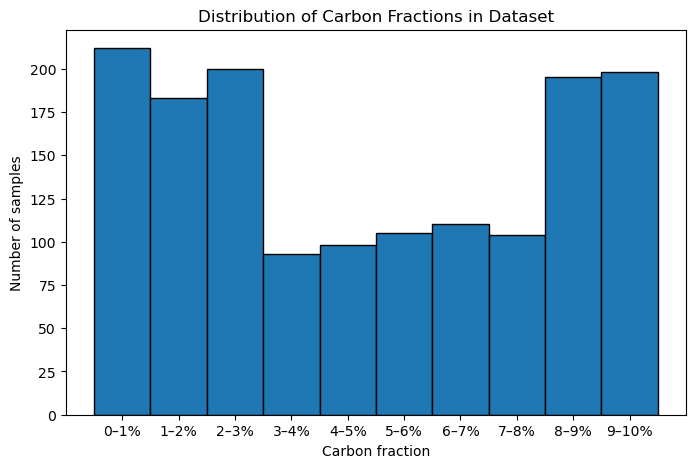

In [7]:
carbon_fractions = Y_combined[:, 0].numpy()

bins = [i/100 for i in range(11)]
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
bin_labels = [f"{int(bins[i]*100)}–{int(bins[i+1]*100)}%" for i in range(len(bins)-1)]

plt.figure(figsize=(8, 5))
plt.hist(carbon_fractions, bins, edgecolor="black")
plt.xlabel("Carbon fraction")
plt.ylabel("Number of samples")
plt.title("Distribution of Carbon Fractions in Dataset")
plt.xticks(bin_centers, bin_labels)
plt.show()

In [81]:
class cCNN_MDN(nn.Module):
    def __init__(self, num_elements=3, num_mixtures=3):
        super().__init__()
        self.num_elements = num_elements  # D -- dimension of target vector
        self.num_mixtures = num_mixtures  # M -- number of Gaussian mixture components

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=9, padding=4),   # [B, 64, 1440]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),                  # [B, 32, 360]

            nn.Conv1d(64, 128, kernel_size=7, padding=3), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),                  # [B, 128, 90]
        )

        self.flatten_dim = 128 * 90  # update it if input structure changes

        self.hidden = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),
            #nn.Dropout(0.3),
        )

        # Output heads:
        self.pi_layer = nn.Linear(64, num_mixtures)                    # [B, M]
        self.mu_layer = nn.Linear(64, num_mixtures * num_elements)     # [B, M*D]
        self.sigma_layer = nn.Linear(64, num_mixtures * num_elements)  # [B, M*D]

    def forward(self, x):
        B = x.size(0)
        x = self.conv_layers(x)
        x = x.view(B, -1)
        x = self.hidden(x)

        # Output parameters : pi, mu, sigma
        pi = F.softmax(self.pi_layer(x), dim=1)  # [B, M]

        mu = self.mu_layer(x).view(B, self.num_mixtures, self.num_elements)  # [B, M, D]
        mu = F.softmax(mu, dim=2)  # fraction (0~1, sum=1)

        sigma = torch.exp(self.sigma_layer(x).view(B, self.num_mixtures, self.num_elements))  # [B, M, D]

        return pi, mu, sigma

In [82]:
def compute_log_likelihood(y, pi, mu, sigma, eps=1e-6):
    """
    Compute log-likelihood for each sample in the batch
    Returns:
        log_likelihoods: Tensor of shape [B]
    """
    B, M, D = mu.shape

    # Expand y to match mu/sigma
    y = y.unsqueeze(1).expand(-1, M, -1)  # [B, M, D]

    # Compute component Gaussian log probs
    normalizer = torch.sqrt(torch.tensor(2.0 * torch.pi, device=y.device))
    coef = 1.0 / (normalizer * sigma + eps)
    exponent = -0.5 * ((y - mu) / (sigma + eps)) ** 2
    probs = coef * torch.exp(exponent)  # [B, M, D]
    probs = torch.prod(probs, dim=2)    # [B, M]

    weighted_probs = probs * pi         # [B, M]
    total_prob = torch.sum(weighted_probs, dim=1) + eps  # [B]

    log_likelihoods = torch.log(total_prob)  # [B]
    return log_likelihoods


def mdn_loss(y, pi, mu, sigma, eps=1e-6):
    log_likelihood = compute_log_likelihood(y, pi, mu, sigma, eps)

    # Mean negative log-likelihood
    return -torch.mean(log_likelihood)


def mdn_loss_std(y, pi, mu, sigma, alpha=5, eps=1e-6, sample_weights=None):
    # Main NLL loss
    nll = mdn_loss(y, pi, mu, sigma, eps)

    # Add weights to nll
    if sample_weights is not None:
        nll = nll * sample_weights  # [B]

    nll_loss = nll.mean()

    # Add sigma penalty
    sigma_penalty = torch.mean(torch.log(1 + 1000*sigma))
    loss = nll_loss + alpha * sigma_penalty

    return loss

In [115]:
# Hyperparameter (grid search in future)
batch_size = 32
epochs = 50
learning_rate = 1e-4

In [116]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [119]:
# Initialize model
model = cCNN_MDN(num_elements=3, num_mixtures=3)  # now we get more mixture components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(batch_size, 1, 1440))

Layer (type:depth-idx)                   Output Shape              Param #
cCNN_MDN                                 [32, 3]                   --
├─Sequential: 1-1                        [32, 128, 90]             --
│    └─Conv1d: 2-1                       [32, 64, 1440]            640
│    └─BatchNorm1d: 2-2                  [32, 64, 1440]            128
│    └─ReLU: 2-3                         [32, 64, 1440]            --
│    └─MaxPool1d: 2-4                    [32, 64, 360]             --
│    └─Conv1d: 2-5                       [32, 128, 360]            57,472
│    └─BatchNorm1d: 2-6                  [32, 128, 360]            256
│    └─ReLU: 2-7                         [32, 128, 360]            --
│    └─MaxPool1d: 2-8                    [32, 128, 90]             --
├─Sequential: 1-2                        [32, 64]                  --
│    └─Linear: 2-9                       [32, 256]                 2,949,376
│    └─ReLU: 2-10                        [32, 256]                 --
│

Epoch 1/50 | Train Loss: 20.3947 | Val Loss: 22.1973
Epoch 2/50 | Train Loss: 8.3969 | Val Loss: 8.5633
Epoch 3/50 | Train Loss: 3.7306 | Val Loss: 2.0273
Epoch 4/50 | Train Loss: 0.8604 | Val Loss: -1.4661
Switching learning rate to 5e-5
Epoch 5/50 | Train Loss: -1.5656 | Val Loss: -2.7232
Epoch 6/50 | Train Loss: -3.0138 | Val Loss: -3.3207
Switching learning rate to 1e-5
Epoch 7/50 | Train Loss: -3.5142 | Val Loss: -3.5451
Epoch 8/50 | Train Loss: -3.6899 | Val Loss: -3.5378
Epoch 9/50 | Train Loss: -3.8156 | Val Loss: -3.8181
Epoch 10/50 | Train Loss: -4.0084 | Val Loss: -3.8857
Epoch 11/50 | Train Loss: -4.2071 | Val Loss: -4.0744
Epoch 12/50 | Train Loss: -4.3313 | Val Loss: -4.1689
Epoch 13/50 | Train Loss: -4.5397 | Val Loss: -4.3687
Epoch 14/50 | Train Loss: -4.7286 | Val Loss: -4.5426
Epoch 15/50 | Train Loss: -4.9587 | Val Loss: -4.7235
Epoch 16/50 | Train Loss: -5.1380 | Val Loss: -4.9088
Switching learning rate to 1e-6
Epoch 17/50 | Train Loss: -5.3478 | Val Loss: -4.9315


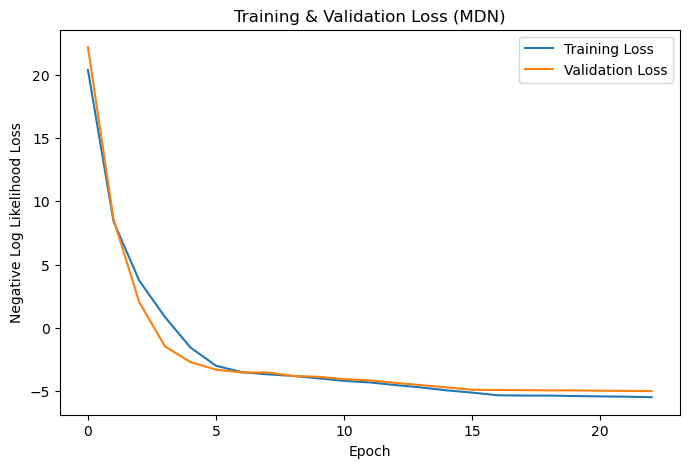

In [120]:
# Training loop
train_losses = []
val_losses = []

lr_switched_1 = False
lr_switched_2 = False
lr_switched_3 = False

gap_history = []
gap_window = 5
early_stop_triggered = False

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        pi, mu, sigma = model(batch_X)
        #sample_weights = compute_asymmetric_sample_weights(batch_Y).to(device)
        loss = mdn_loss_std(batch_Y, pi, mu, sigma, alpha=5, eps=1e-6, sample_weights=None)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            pi, mu, sigma = model(val_X)
            #sample_weights = compute_asymmetric_sample_weights(val_Y).to(device)
            loss = mdn_loss_std(val_Y, pi, mu, sigma, alpha=5, eps=1e-6, sample_weights=None)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    gap = avg_val_loss - avg_train_loss
    gap_history.append(gap)

    if len(gap_history) > gap_window:
        gap_history.pop(0)  # only keep N recent gap value

        if epoch >= 20 and avg_val_loss <= -4:  
            # If N recent gap strictly increasing
            if all(gap_history[i] < gap_history[i + 1] for i in range(gap_window - 1)):
                print(f"Early stop at {gap_window} epochs")
                early_stop_triggered = True
                break
    
    # Switch learning rate
    if not lr_switched_1 and avg_train_loss < 3:
        print("Switching learning rate to 5e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-5
        lr_switched_1 = True

    if not lr_switched_2 and avg_train_loss < -3:
        print("Switching learning rate to 1e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5
        lr_switched_2 = True

    if not lr_switched_3 and avg_train_loss < -5:
        print("Switching learning rate to 1e-6")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-6
        lr_switched_3 = True

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("Training & Validation Loss (MDN)")
plt.legend()
plt.show()

In [122]:
def mdn_predict_mean(pi, mu):
    return torch.sum(pi.unsqueeze(-1) * mu, dim=1)  # [B, D]

def mdn_predict_std(pi, mu, sigma):
    # Expected mean: E[y] = sum(pi * mu)
    mean = torch.sum(pi.unsqueeze(2) * mu, dim=1)  # shape: [B, D]

    # Variance: Var[y] = sum(pi * (sigma^2 + (mu - E[y])^2))
    var = torch.sum(
        pi.unsqueeze(2) * (sigma ** 2 + (mu - mean.unsqueeze(1)) ** 2),
        dim=1
    )  # shape: [B, D]

    std = torch.sqrt(var + 1e-8)
    return std

In [123]:
model.eval()

all_preds = []
all_targets = []
all_stds = []

all_pi = []
all_mu = []
all_sigma = []

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X = val_X.to(device)
        val_Y = val_Y.to(device)

        pi, mu, sigma = model(val_X)            # [B, M], [B, M, D], [B, M, D]
        y_pred = mdn_predict_mean(pi, mu)       # [B, D]
        y_std = mdn_predict_std(pi, mu, sigma)  # [B, D]

        all_preds.append(y_pred.cpu())
        all_targets.append(val_Y.cpu())
        all_stds.append(y_std.cpu())

        all_pi.append(pi.cpu())
        all_mu.append(mu.cpu())
        all_sigma.append(sigma.cpu())

all_preds = torch.cat(all_preds, dim=0)         # [N, D]
all_targets = torch.cat(all_targets, dim=0)     # [N, D]
all_stds = torch.cat(all_stds, dim=0)           # [N, D]

all_pi = torch.cat(all_pi, dim=0)               # [N, M]
all_mu = torch.cat(all_mu, dim=0)               # [N, M, D]
all_sigma = torch.cat(all_sigma, dim=0)         # [N, M, D]

In [124]:
def compute_mae(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true))

mae = compute_mae(all_preds, all_targets)

print(f"MAE: {mae:.4f}")

MAE: 0.0098


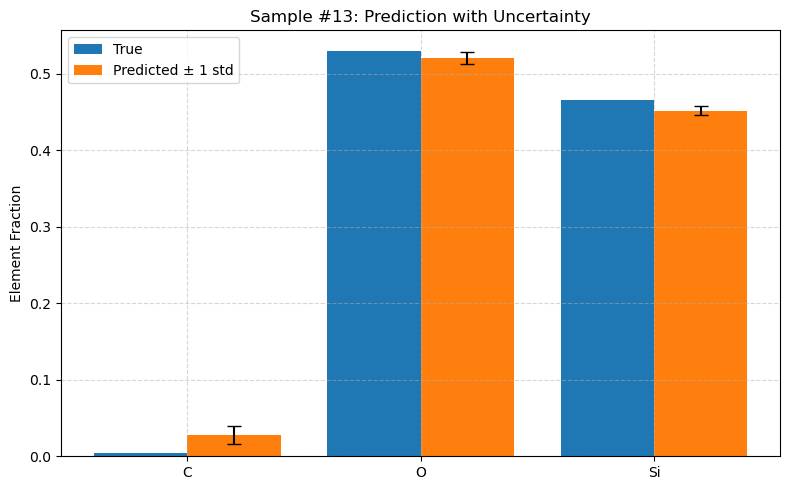

In [125]:
# Take one sample
# To see uncertainty

i = 13
x = torch.arange(len(element_list))

plt.figure(figsize=(8, 5))
plt.bar(x-0.2, all_targets[i], width=0.4, label="True")
plt.bar(x+0.2, all_preds[i], width=0.4, yerr=all_stds[i],
        capsize=5, label="Predicted ± 1 std")

plt.xticks(x, element_list)
plt.ylabel("Element Fraction")
plt.title(f"Sample #{i}: Prediction with Uncertainty")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [126]:
def gaussian_pdf(x, mu, sigma):
    """compute 1D Gaussian PDF."""
    coef = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    exponent = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return coef * exponent

def plot_mdn_distribution(idx, d, all_pi, all_mu, all_sigma, all_targets):
    """
    idx: sample index
    d: dimension index (e.g. 0 = C, 1 = O, 2 = Si)
    """
    pi = all_pi[idx].numpy()              # [M]
    mu = all_mu[idx, :, d].numpy()        # [M]
    sigma = all_sigma[idx, :, d].numpy()  # [M]
    y_true = all_targets[idx, d].item()

    x = np.linspace(0.0, 0.1, 500)
    pdf = np.zeros_like(x)

    for k in range(len(pi)):
        pdf += pi[k] * gaussian_pdf(x, mu[k], sigma[k])

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x, pdf, label=f"Predicted PDF for Element {element_list[d]}", color="orange")
    plt.axvline(y_true, color="blue", linestyle="--", label="True Value")
    plt.title(f"Sample #{idx}: MDN Predicted Distribution for Element {element_list[d]}")
    plt.xlabel("Element Fraction")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

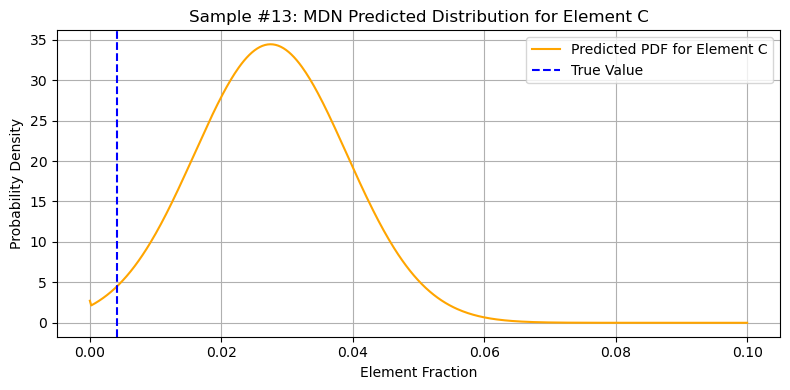

In [127]:
plot_mdn_distribution(idx=13, d=0, 
                      all_pi=all_pi,
                      all_mu=all_mu,
                      all_sigma=all_sigma,
                      all_targets=all_targets)

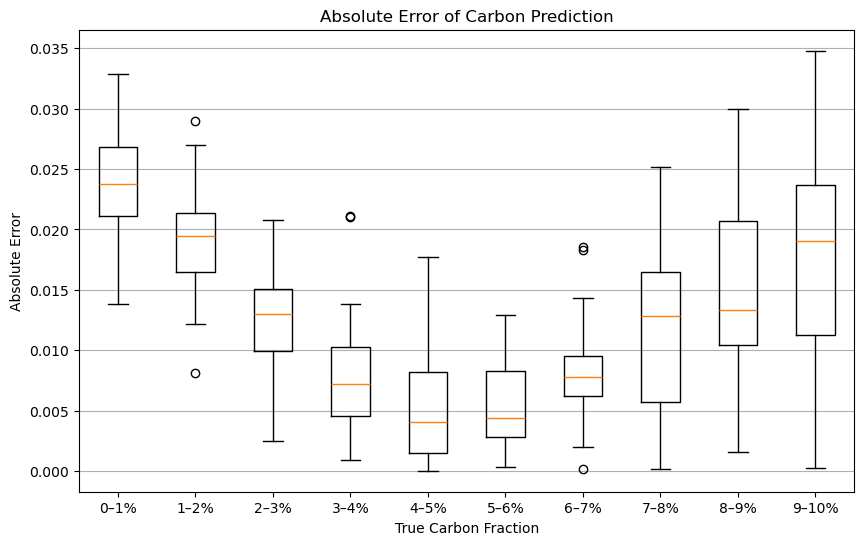

In [128]:
carbon_index = 0
true_C = all_targets[:, carbon_index].numpy()
pred_C = all_preds[:, carbon_index].numpy()
abs_errors = np.abs(true_C - pred_C)

# bins：0-1%, 1-2%, ..., 9-10%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Split samples by bins
bin_indices = np.digitize(true_C, bins) - 1  # bin index from 0 to 9

# Collect abs error in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
for idx, err in zip(bin_indices, abs_errors):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)

# plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_errors, tick_labels=bin_labels, showfliers=True)
plt.xlabel("True Carbon Fraction")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of Carbon Prediction")
plt.grid(True, axis="y")
plt.show()

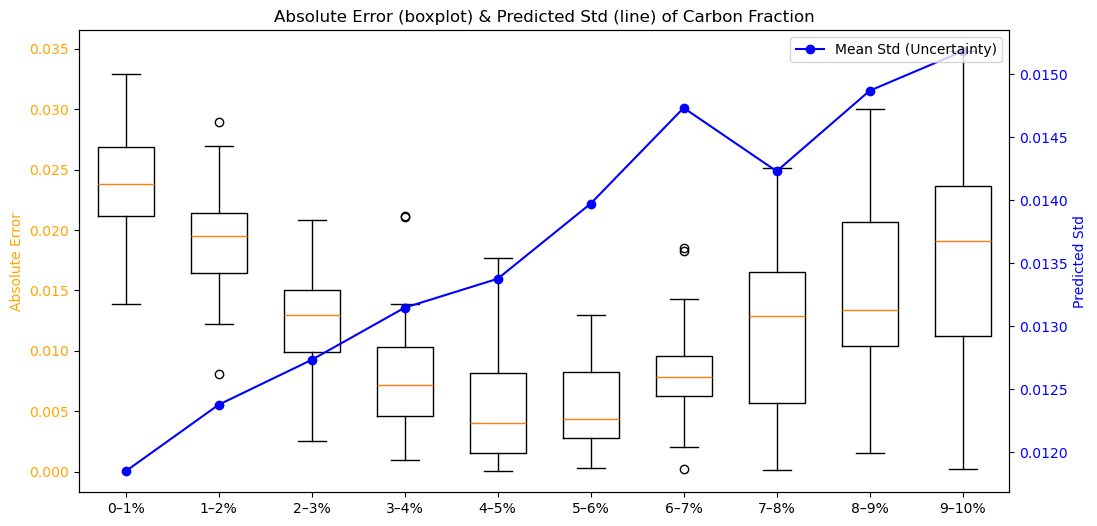

In [129]:
# Add std line plot

std_C = all_stds[:, carbon_index].numpy() 

# bins：0-10%, 10-20%, ..., 90-100%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]
bin_indices = np.digitize(true_C, bins) - 1  # Bin index: 0 to 9

# Correct abs error and stf in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
grouped_stds = [[] for _ in range(len(bins) - 1)]
for idx, err, std in zip(bin_indices, abs_errors, std_C):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)
        grouped_stds[idx].append(std)

# mean std for each bin
std_means = [np.mean(s) if len(s) > 0 else 0 for s in grouped_stds]
#print(std_means)
x_pos = np.arange(len(bin_labels))

# plot
# left: boxplot; right: std
fig, ax1 = plt.subplots(figsize=(12, 6))

# Boxplot for abs error
box = ax1.boxplot(grouped_errors, positions=x_pos, widths=0.6)
ax1.set_ylabel("Absolute Error", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")

# Line plot for std
ax2 = ax1.twinx()
ax2.plot(x_pos, std_means, color="blue", marker="o", label="Mean Std (Uncertainty)")
ax2.set_ylabel("Predicted Std", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.legend(loc="upper right")

plt.xticks(x_pos, bin_labels)
plt.title("Absolute Error (boxplot) & Predicted Std (line) of Carbon Fraction")
plt.show()

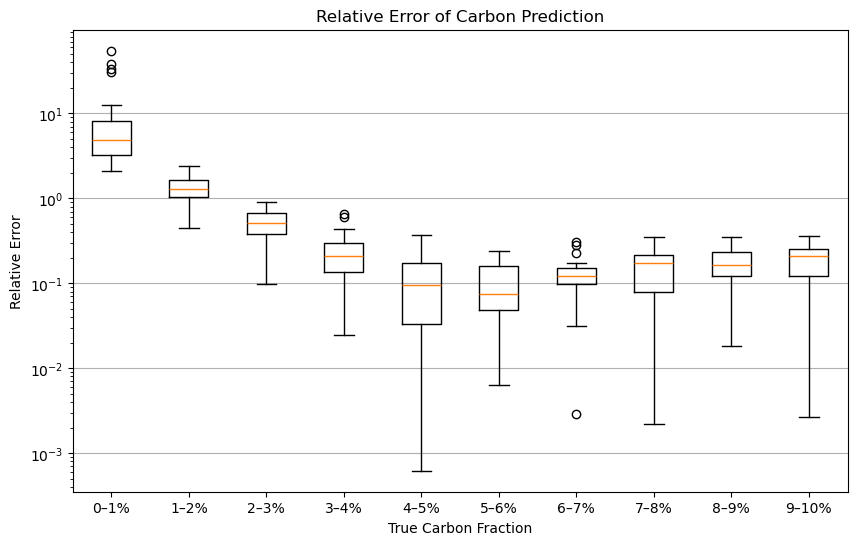

In [130]:
# Relative Error

rel_errors = np.abs(true_C - pred_C) / np.clip(true_C, 1e-6, None) # avoid 0

# bins：0-1%, 1-2%, ..., 9-10%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Split samples by bins
bin_indices = np.digitize(true_C, bins) - 1  # bin index from 0 to 9

# Collect rel error in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
for idx, err in zip(bin_indices, rel_errors):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)

# plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_errors, tick_labels=bin_labels, showfliers=True)
plt.yscale("log")
plt.xlabel("True Carbon Fraction")
plt.ylabel("Relative Error")
plt.title("Relative Error of Carbon Prediction")
plt.grid(True, axis="y")
plt.show()

In [131]:
residuals = (true_C - pred_C)

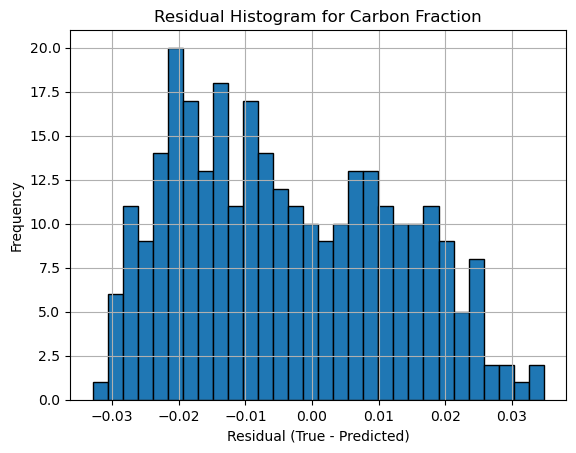

In [132]:
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Histogram for Carbon Fraction")
plt.grid(True)
plt.show()

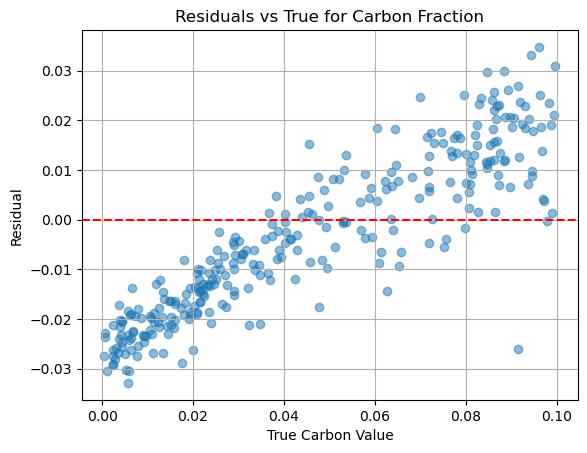

In [133]:
plt.scatter(true_C, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True Carbon Value")
plt.ylabel("Residual")
plt.title("Residuals vs True for Carbon Fraction")
plt.grid(True)
plt.show()

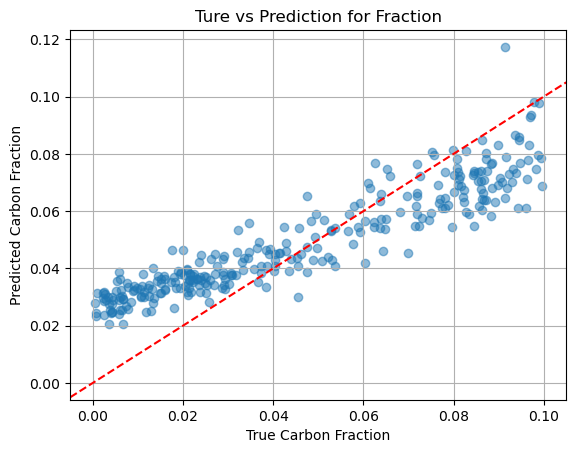

In [134]:
plt.scatter(true_C, pred_C, alpha=0.5)
plt.axline(xy1=(0.1,0.1), xy2=(0,0), color="red", linestyle="--")
plt.xlabel("True Carbon Fraction")
plt.ylabel("Predicted Carbon Fraction")
plt.title("Ture vs Prediction for Fraction")
plt.grid(True)
plt.show()

In [135]:
# [pred-std, pred+std]
lower_bound = pred_C - std_C
upper_bound = pred_C + std_C

# Determine whether within the interval
within = (true_C >= lower_bound) & (true_C <= upper_bound)

# Compute coverage rate
coverage_rate = np.mean(within)
print(f"[Carbon] pred ± 1 std converage：{coverage_rate * 100:.2f}%")

[Carbon] pred ± 1 std converage：47.33%


In [136]:
# 95% CI (mean +- 1.96*std)
# [pred-std, pred+std]
lower_bound = pred_C - 1.96*std_C
upper_bound = pred_C + 1.96*std_C

# Determine whether within the interval
within = (true_C >= lower_bound) & (true_C <= upper_bound)

# Compute coverage rate
coverage_rate = np.mean(within)
print(f"[Carbon] pred ± 1.96 std converage：{coverage_rate * 100:.2f}%")

[Carbon] pred ± 1.96 std converage：87.67%


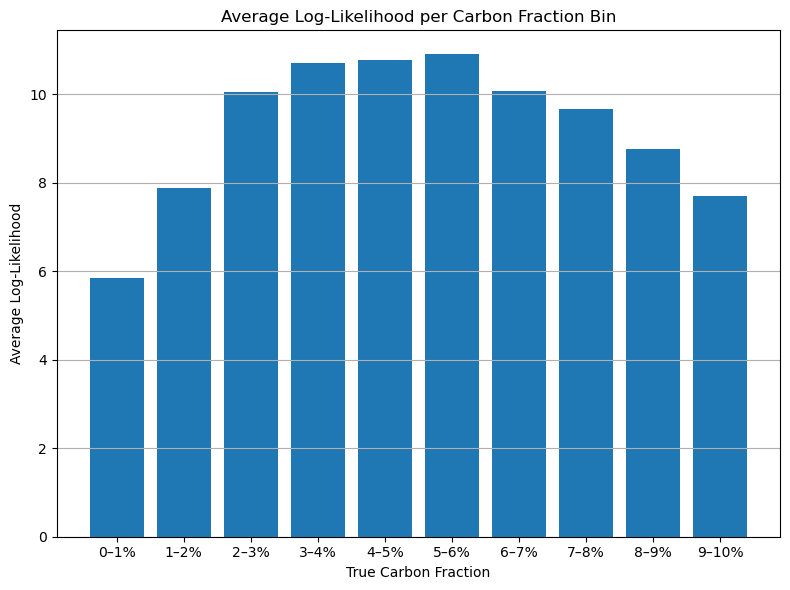

In [137]:
# Plot log-likelihood by bins

# bins: 0-1%, 1-2%, ..., 9-10%
bins = np.linspace(0.0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Collect average log-likelihood per bin
bin_log_likelihoods = []

for i in range(len(bins) - 1):
    lower, upper = bins[i], bins[i+1]
    mask = (true_C >= lower) & (true_C < upper)

    if mask.sum() == 0:
        bin_log_likelihoods.append(float("nan"))  # if no sample in bin
        continue

    subset_y = all_targets[mask]           # [n_bin, D]
    subset_pi = all_pi[mask]               # [n_bin, M]
    subset_mu = all_mu[mask]               # [n_bin, M, D]
    subset_sigma = all_sigma[mask]         # [n_bin, M, D]

    log_liks = compute_log_likelihood(subset_y, subset_pi, subset_mu, subset_sigma)
    avg_ll = log_liks.mean().item()
    bin_log_likelihoods.append(avg_ll)

# Plot log-likelihood for each bin
plt.figure(figsize=(8, 6))
plt.bar(bin_labels, bin_log_likelihoods)
plt.xlabel("True Carbon Fraction")
plt.ylabel("Average Log-Likelihood")
plt.title("Average Log-Likelihood per Carbon Fraction Bin")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Test set (5%-6% C)

In [140]:
model.eval()

all_preds = []
all_targets = []
all_stds = []

all_pi = []
all_mu = []
all_sigma = []

with torch.no_grad():
    for test_X, test_Y in test_loader:
        test_X = test_X.to(device)
        test_Y = test_Y.to(device)

        pi, mu, sigma = model(test_X)            # [B, M], [B, M, D], [B, M, D]
        y_pred = mdn_predict_mean(pi, mu)       # [B, D]
        y_std = mdn_predict_std(pi, mu, sigma)  # [B, D]

        all_preds.append(y_pred.cpu())
        all_targets.append(test_Y.cpu())
        all_stds.append(y_std.cpu())

        all_pi.append(pi.cpu())
        all_mu.append(mu.cpu())
        all_sigma.append(sigma.cpu())

all_preds = torch.cat(all_preds, dim=0)         # [N, D]
all_targets = torch.cat(all_targets, dim=0)     # [N, D]
all_stds = torch.cat(all_stds, dim=0)           # [N, D]

all_pi = torch.cat(all_pi, dim=0)               # [N, M]
all_mu = torch.cat(all_mu, dim=0)               # [N, M, D]
all_sigma = torch.cat(all_sigma, dim=0)         # [N, M, D]

true_C = all_targets[:,0].numpy()
pred_C = all_preds[:,0].numpy()

In [141]:
# Compute average log-likelihood
log_liks = compute_log_likelihood(all_targets, all_pi, all_mu, all_sigma)
avg_ll = log_liks.mean().item()

print("Average log-likelihood on C 5% ~ 6%:", avg_ll)


# Compute mean absolute error
pred_C_tensor = torch.from_numpy(pred_C)

mae = compute_mae(pred_C_tensor, true_C)

print(f"MAE: {mae:.4f}")

Average log-likelihood on C 5% ~ 6%: 10.703020095825195
MAE: 0.0056


/tmp/ipykernel_22743/4099152831.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return torch.mean(torch.abs(y_pred - y_true))


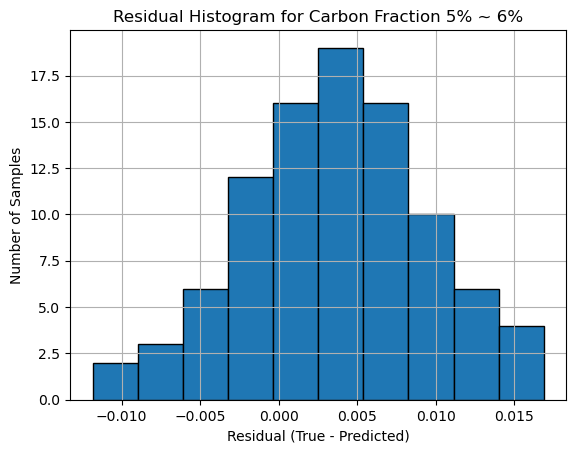

In [142]:
all_residuals = (true_C - pred_C)

plt.hist(all_residuals, bins=10, edgecolor="black")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Number of Samples")
plt.title("Residual Histogram for Carbon Fraction 5% ~ 6%")
plt.grid(True)
plt.show()

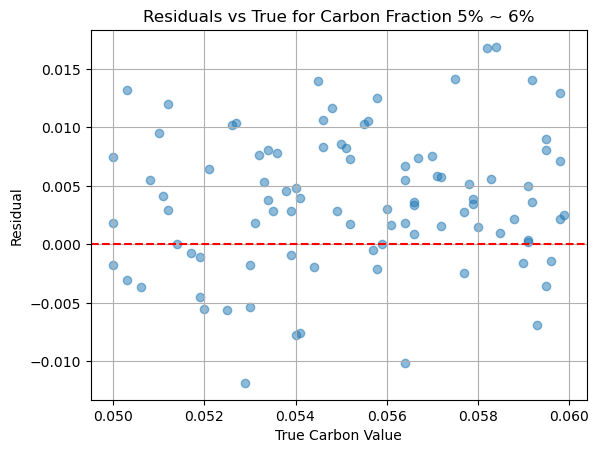

In [144]:
plt.scatter(true_C, all_residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True Carbon Value")
plt.ylabel("Residual")
plt.title("Residuals vs True for Carbon Fraction 5% ~ 6%")
plt.grid(True)
plt.show()

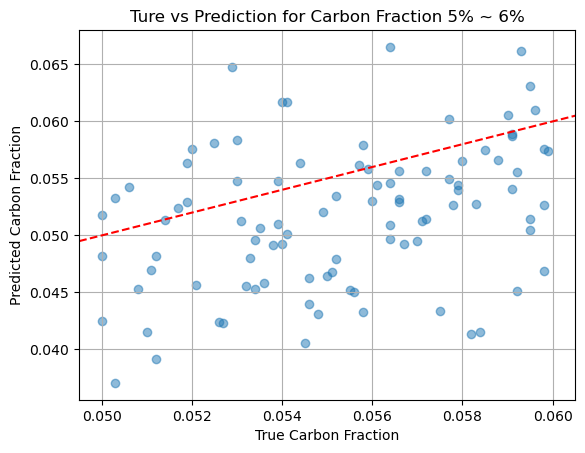

In [145]:
plt.scatter(true_C, pred_C, alpha=0.5)
plt.axline(xy1=(0.05,0.05), xy2=(0.06,0.06), color="red", linestyle="--")
plt.xlabel("True Carbon Fraction")
plt.ylabel("Predicted Carbon Fraction")
plt.title("Ture vs Prediction for Carbon Fraction 5% ~ 6%")
plt.grid(True)
plt.show()